In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from neo4j import GraphDatabase
import json
# from py2neo import Graph
import random
from tqdm import tqdm
import pickle


In [5]:
bio_df = pd.read_excel('data/expression_data.xlsx', engine='openpyxl')



In [6]:
bio_df = bio_df.drop(bio_df.columns[0], axis=1)
proteins = bio_df.columns.tolist()

In [7]:
uniprot_to_reactome = pd.read_csv('data/MMU_Uniprot2Reactome.txt', sep='\t')

existing_proteins = uniprot_to_reactome[uniprot_to_reactome['V1'].isin(proteins)]['V1'].unique()

existing_proteins_list = existing_proteins.tolist()
len(existing_proteins_list)

1631

In [5]:
filtered_df = bio_df[existing_proteins_list]
filtered_df

,A0A0G2JE99,A0A286YCX6,A2AF47,A2AIV8,A2AM29,A2APB8,A2APC3,A2APY7,A2AQ07,A2AR02,...,Q9Z1Z2,Q9Z2D0,Q9Z2D1,Q9Z2D3,Q9Z2I9,Q9Z2M7,Q9Z2V5,Q9Z2X1,Q9Z2X2,Q9Z2Z9
0,0,162010.0,125760.0,0.0,15104.0,109740.0,67069.00,27275.0,40522.0,273390,...,2494000,20249.0,176690,255050,69902.0,175920,198910,6838400,393630,173190.0
1,0,167320.0,0.0,0.0,8574.6,116490.0,88118.00,31187.0,40570.0,217250,...,2334000,22413.0,167940,308010,69789.0,172240,216860,6752500,442120,83790.0
2,0,51649.0,0.0,0.0,10085.0,49893.0,124690.00,92364.0,39478.0,19164,...,2063700,2293.4,115320,86602,2482.1,37705,207340,5448300,359080,0.0
3,28979,13440.0,52032.0,0.0,12123.0,159700.0,0.00,33011.0,26715.0,271680,...,2174900,5152.3,115790,129890,108690.0,367500,109640,6404800,252500,162590.0
4,0,159740.0,0.0,0.0,6523.1,44042.0,77081.00,45720.0,57331.0,213460,...,2318300,19318.0,147760,204760,122880.0,306030,191870,6147200,443340,266710.0
5,0,103780.0,0.0,0.0,13429.0,164280.0,52180.00,69290.0,50447.0,160470,...,2122600,9910.4,88441,291390,76940.0,373750,118760,6005900,236300,228000.0
6,0,126620.0,59234.0,0.0,6477.1,28037.0,0.00,17809.0,32387.0,250090,...,1766100,15817.0,38631,158870,73311.0,197240,130020,4152700,385540,3416.8
7,0,132010.0,17986.0,0.0,5812.8,95160.0,42151.00,39341.0,48215.0,140010,...,1823100,6913.5,63605,130250,86056.0,206880,134410,4727300,306190,0.0
8,0,65848.0,0.0,9401.6,6586.5,43317.0,0.00,13514.0,45938.0,275070,...,1505500,1436.6,26911,147490,183430.0,190910,159600,5192100,301570,0.0
9,0,161540.0,21179.0,0.0,3319.8,31962.0,0.00,20161.0,34026.0,225620,...,1560900,4941.0,49929,160390,157680.0,196000,108290,4975300,467760,429350.0


In [6]:
correlation_matrix_pearson = filtered_df.corr(method='pearson')

correlation_matrix_spearman = filtered_df.corr(method='spearman')

# correlation_matrix.to_csv('protein_correlation_matrix.csv')
correlation_matrix_pearson

,A0A0G2JE99,A0A286YCX6,A2AF47,A2AIV8,A2AM29,A2APB8,A2APC3,A2APY7,A2AQ07,A2AR02,...,Q9Z1Z2,Q9Z2D0,Q9Z2D1,Q9Z2D3,Q9Z2I9,Q9Z2M7,Q9Z2V5,Q9Z2X1,Q9Z2X2,Q9Z2Z9
A0A0G2JE99,1.000000,0.241979,0.554018,0.811818,0.656745,-0.563696,-0.430069,0.494220,0.194667,-0.464788,...,-0.462694,0.466031,-0.419337,-0.451984,-0.291856,0.234145,-0.005083,0.065996,-0.708386,-0.296252
A0A286YCX6,0.241979,1.000000,0.165233,0.441802,0.037576,-0.281828,0.060129,0.035330,-0.045214,0.251578,...,0.181683,0.478879,0.037139,0.151609,-0.062300,0.123511,0.217737,-0.072408,0.082688,0.001689
A2AF47,0.554018,0.165233,1.000000,0.456688,0.496201,-0.304292,-0.352923,0.477040,0.440041,-0.395490,...,-0.217680,0.229398,-0.258030,-0.370647,-0.258530,0.123390,-0.266285,0.386288,-0.666360,-0.117772
A2AIV8,0.811818,0.441802,0.456688,1.000000,0.311181,-0.549155,-0.413758,0.327987,0.154547,-0.375343,...,-0.380588,0.627394,-0.364919,-0.495193,-0.288321,0.234207,0.016411,-0.093447,-0.592256,-0.295541
A2AM29,0.656745,0.037576,0.496201,0.311181,1.000000,-0.210629,-0.079872,0.635853,0.344947,-0.327589,...,-0.113376,0.214472,-0.103273,-0.053627,-0.229645,0.153083,0.165175,0.263475,-0.455914,-0.251591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2M7,0.234145,0.123511,0.123390,0.234207,0.153083,0.022817,-0.366874,0.192513,0.042171,0.069403,...,-0.127658,0.293881,-0.049862,0.112661,0.046401,1.000000,0.162474,-0.115348,-0.192374,-0.056956
Q9Z2V5,-0.005083,0.217737,-0.266285,0.016411,0.165175,0.045766,0.439457,0.166486,-0.196385,0.271819,...,0.341078,0.533930,0.420975,0.408199,-0.196610,0.162474,1.000000,-0.017897,0.384666,-0.229474
Q9Z2X1,0.065996,-0.072408,0.386288,-0.093447,0.263475,0.156714,0.252847,0.338547,0.300337,-0.193043,...,0.442239,-0.039900,0.319234,0.206457,-0.370563,-0.115348,-0.017897,1.000000,-0.214556,-0.260998
Q9Z2X2,-0.708386,0.082688,-0.666360,-0.592256,-0.455914,0.360580,0.530947,-0.430796,-0.330589,0.568316,...,0.511589,-0.096624,0.458431,0.584237,0.237444,-0.192374,0.384666,-0.214556,1.000000,0.131245


In [7]:
correlation_matrix_spearman

,A0A0G2JE99,A0A286YCX6,A2AF47,A2AIV8,A2AM29,A2APB8,A2APC3,A2APY7,A2AQ07,A2AR02,...,Q9Z1Z2,Q9Z2D0,Q9Z2D1,Q9Z2D3,Q9Z2I9,Q9Z2M7,Q9Z2V5,Q9Z2X1,Q9Z2X2,Q9Z2Z9
A0A0G2JE99,1.000000,0.191474,0.682775,0.842548,0.335428,-0.667281,-0.500179,0.369942,0.021479,-0.526315,...,-0.479161,0.405095,-0.414995,-0.580525,-0.301401,0.101347,-0.065414,0.142047,-0.724902,-0.261563
A0A286YCX6,0.191474,1.000000,0.164586,0.366948,-0.007285,-0.268740,0.099544,-0.013761,0.023877,0.219473,...,0.164894,0.391536,0.042091,0.172126,-0.098404,-0.065796,0.152752,0.029949,0.167438,0.086351
A2AF47,0.682775,0.164586,1.000000,0.538625,0.086412,-0.493344,-0.493327,0.111039,-0.010516,-0.376832,...,-0.442374,0.154883,-0.469896,-0.611371,-0.190949,0.042718,-0.347723,0.122600,-0.609401,-0.161650
A2AIV8,0.842548,0.366948,0.538625,1.000000,0.194017,-0.714474,-0.431525,0.264197,0.000275,-0.435272,...,-0.504965,0.445267,-0.424455,-0.518809,-0.290272,0.032724,-0.023824,-0.005340,-0.561787,-0.330031
A2AM29,0.335428,-0.007285,0.086412,0.194017,1.000000,0.050880,0.191909,0.650921,0.272348,-0.170907,...,0.218085,0.523127,0.235430,0.233066,-0.368525,0.114130,0.465888,0.380319,-0.180389,0.030374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2M7,0.101347,-0.065796,0.042718,0.032724,0.114130,0.065682,-0.258670,0.196467,0.146805,0.121415,...,-0.124769,0.123497,-0.004625,0.076725,0.038506,1.000000,0.067761,-0.104995,-0.138414,0.054348
Q9Z2V5,-0.065414,0.152752,-0.347723,-0.023824,0.465888,0.028562,0.364914,0.246133,-0.146805,0.159806,...,0.292900,0.579787,0.378238,0.349629,-0.158187,0.067761,1.000000,0.011216,0.344126,0.017573
Q9Z2X1,0.142047,0.029949,0.122600,-0.005340,0.380319,0.163684,0.312629,0.291001,0.306449,-0.164778,...,0.456984,0.086031,0.370028,0.216877,-0.294403,-0.104995,0.011216,1.000000,-0.124884,-0.047714
Q9Z2X2,-0.724902,0.167438,-0.609401,-0.561787,-0.180389,0.407678,0.537679,-0.215779,-0.045198,0.486124,...,0.535846,0.023936,0.444380,0.627851,0.228377,-0.138414,0.344126,-0.124884,1.000000,0.227050


In [54]:
threshold = 0.8

# Find where the absolute value of correlations is greater than the threshold
filtered_correlations = correlation_matrix_pearson.where(
    (abs(correlation_matrix) > threshold) & (correlation_matrix != 1.0), 0)

# Identify pairs which are highly correlated
highly_correlated_pairs = [(i, j) for i in filtered_correlations.index for j in filtered_correlations.columns if filtered_correlations.at[i, j] != 0]

highly_correlated_pairs_with_values = [(i, j, filtered_correlations.at[i, j]) for i, j in highly_correlated_pairs]
highly_correlated_pairs_with_values

[('A0A0G2JE99', 'A2AIV8', 0.811818031794204),
 ('A0A0G2JE99', 'O08912', 0.8065366726153312),
 ('A0A0G2JE99', 'O09159', 0.8985181574853643),
 ('A0A0G2JE99', 'O35459', 0.9099689895818648),
 ('A0A0G2JE99', 'P01027', 0.8972895194741832),
 ('A0A0G2JE99', 'P01029', 0.8148454747843001),
 ('A0A0G2JE99', 'P01942', 0.9102196781718612),
 ('A0A0G2JE99', 'P03911', 0.8385120259276099),
 ('A0A0G2JE99', 'P06728', 0.8870914446985291),
 ('A0A0G2JE99', 'P07309', 0.8788801026638121),
 ('A0A0G2JE99', 'P07724', 0.888570032690969),
 ('A0A0G2JE99', 'P09411', -0.8084629519344139),
 ('A0A0G2JE99', 'P10107', 0.8755084949119258),
 ('A0A0G2JE99', 'P10649', 0.8007563730627951),
 ('A0A0G2JE99', 'P11352', 0.8362845556054871),
 ('A0A0G2JE99', 'P11680', 0.8138483007045925),
 ('A0A0G2JE99', 'P13020', 0.8953383332446625),
 ('A0A0G2JE99', 'P14733', 0.8435966403536326),
 ('A0A0G2JE99', 'P15626', 0.8678791955879912),
 ('A0A0G2JE99', 'P19324', 0.8840574731074115),
 ('A0A0G2JE99', 'P20491', 0.8029569238568846),
 ('A0A0G2JE99'

In [8]:
import torch
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
Z = torch.load('clusterGCN_embedding.pt').detach().numpy()

Z_normalized = Z / np.linalg.norm(Z, axis=1, keepdims=True)
# Compute dot product
similarity_matrix = np.dot(Z_normalized, Z_normalized.T)
# print(similarity_matrix)

# Apply sigmoid function to convert scores to probabilities
adjacency_matrix_reconstructed = sigmoid(similarity_matrix)
print(adjacency_matrix_reconstructed.shape)

# # Normalize the embeddings if they aren't already
# normalized_embeddings = normalize(embeddings)

# # Convert the correlation matrix to a numpy array and normalize it
# normalized_correlation_matrix = normalize(correlation_matrix.values)

# # Compute cosine similarity between the normalized embeddings and the normalized correlation matrix
# # The shape of the resulting array will be (number of embeddings) x (number of features in correlation matrix)
# cosine_sim_matrix = cosine_similarity(normalized_embeddings, normalized_correlation_matrix)

# # Convert the cosine similarity matrix to a DataFrame for easier analysis
# cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=correlation_matrix.index, columns=correlation_matrix.columns)


(50164, 50164)


In [35]:
len(existing_proteins_list)


1631

## queries that may be useful

```cypher
UNWIND $proteinNames AS proteinName
MATCH (p)-[rel1]-()-[rel2]-(connectedNodes)
WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p)) 
  AND connectedNodes.speciesName = 'Mus musculus' 
  AND ANY(name IN p.name WHERE name = proteinName)
RETURN p AS protein, collect(DISTINCT rel1) + collect(DISTINCT rel2) AS relationships, collect(DISTINCT connectedNodes) AS nodes
```



```cypher
UNWIND $proteinNames AS proteinName
MATCH path = (p)-[*2]-(connectedNodes)
WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p)) 
  AND connectedNodes.speciesName = 'Mus musculus' 
  AND ANY(name IN p.name WHERE name = proteinName)
RETURN p AS protein, [r in relationships(path) | r] AS relationships, collect(DISTINCT connectedNodes) AS nodes
LIMIT 2
```




```cypher
UNWIND $proteinNames AS proteinName
MATCH (p)
WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p))
  AND ANY(name IN p.name WHERE name = proteinName)
CALL apoc.path.subgraphAll(p, {
  maxLevel: 2,
  relationshipFilter: ">", // Adjust this based on your relationship types
  labelFilter: "/Mus musculus", // Adjust this to filter the end nodes, use + for include, - for exclude
  endNodeFilter: "Mus musculus" // This is not a native option, demonstrating intent
})
YIELD nodes, relationships
RETURN p AS protein, nodes, relationships
```





```cypher
UNWIND $proteinNames AS proteinName
MATCH (p)-[rel]-(connectedNodes)
WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p)) AND connectedNodes.speciesName = 'Mus musculus' AND ANY(name IN p.name WHERE name = proteinName)
RETURN p AS protein, collect(rel) AS relationships, collect(connectedNodes) AS nodes
```


        MATCH (p {dbId: '9896799'})-[rel]-(connectedNodes)
        WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p)) AND connectedNodes.speciesName = 'Mus musculus'
        RETURN connectedNodes
        limit 2




MATCH (protein)
WHERE ('EntityWithAccessionedSequence' IN labels(protein) OR 'GenomeEncodedEntity' IN labels(protein))
  AND ANY(name IN protein.name WHERE name = "A2AF47")
CALL apoc.path.expand(
  protein, 
  null,
  null,
  1, 
  2
) YIELD path
WITH protein, 
     [node IN nodes(path) WHERE node.speciesName = 'Mus musculus'] AS filteredNodes,
     relationships(path) AS allRelationships
UNWIND filteredNodes AS fn
WITH protein, COLLECT(DISTINCT fn) AS uniqueFilteredNodes, allRelationships
RETURN protein AS P, uniqueFilteredNodes AS Nodes, allRelationships AS Relationships
        

# Extract connected nodes to the specific proteins from reactome using neo4j

In [15]:
from tqdm import tqdm
import pickle





def fetch_and_create_graph(driver, protein_names, batch_size=10):
    num_batches = len(protein_names) // batch_size + (1 if len(protein_names) % batch_size > 0 else 0)
    G = nx.MultiGraph()
    
    for i in tqdm(range(num_batches), desc="Processing batches"):
        batch = protein_names[i*batch_size:(i+1)*batch_size]
        with driver.session() as session:
            for record in session.run("""
                UNWIND $proteinNames AS proteinName
                MATCH (p)
                WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p))
                  AND ANY(name IN p.name WHERE name = proteinName)
                CALL apoc.path.subgraphAll(p, {
                  maxLevel: 2,
                  minLevel:1
                })
                YIELD nodes, relationships
                WITH p, 
                     [node in nodes WHERE 'Mus musculus' IN labels(node) OR node.speciesName = 'Mus musculus'] AS filteredNodes,
                     relationships
                RETURN p AS protein, filteredNodes AS nodes, relationships
            """, {"proteinNames": batch}):
                # Add nodes and edges to the graph directly
                protein_node = record['protein']
                G.add_node(protein_node.id, **protein_node._properties)
                for node in record['nodes']:
                    G.add_node(node.id, **node._properties)
                    
                for rel in record['relationships']:
                    G.add_edge(rel.start_node.id, rel.end_node.id, **rel._properties)
    
    
    return G


def convert_attributes_to_strings(G):
    for node, data in G.nodes(data=True):
        for key, value in data.items():
            if isinstance(value, (list, dict)):  
                G.nodes[node][key] = json.dumps(value)
    
    for u, v, data in G.edges(data=True):
        for key, value in data.items():
            if isinstance(value, (list, dict)): 
                G.edges[u, v][key] = json.dumps(value)
    
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "123456789"))


aggregated_graph = fetch_and_create_graph(driver, existing_proteins_list[30:40])

driver.close()

# convert_attributes_to_strings(aggregated_graph)
# print("before writing")
# nx.write_graphml(aggregated_graph, "aggregated_proteins_v30-40_subgraph.graphml")
# # with open("aggregated_proteins_v30_subgraph.pkl", "wb") as f:
# #     pickle.dump(aggregated_graph, f)
# print("after writing")


Processing batches:   0%|                               | 0/1 [6:20:35<?, ?it/s]

KeyboardInterrupt



In [14]:
convert_attributes_to_strings(aggregated_graph)
print("before writing")
# nx.write_graphml(aggregated_graph, "aggregated_proteins_v10-20_subgraph.graphml")
with open("aggregated_proteins_v100-110_subgraph.pkl", "wb") as f:
    pickle.dump(aggregated_graph, f)
print("after writing")

before writing
after writing


In [2]:


# # List of specific pickle files
# files = [
#     'combined_graph.pkl',
#     'aggregated_proteins_v70-80_subgraph.pkl',
#     'aggregated_proteins_v80-90_subgraph.pkl'
# ]

# # List to hold all graphs
# graphs = []

# # Load each graph from the specified pickle files
# for file_path in files:
#     graph = load_graph_from_pickle(file_path)
#     graphs.append(graph)

# # Combine all graphs into a single graph
# combined_graph = nx.compose_all(graphs)

# # Save the combined graph to a new pickle file
# output_path = 'combined_graph_final.pkl'
# with open(output_path, 'wb') as f:
#     pickle.dump(combined_graph, f)

# print("Combined graph has been saved to:", output_path)




In [3]:

import networkx as nx
import pickle

# Function to load a graph from a pickle file
def load_graph_from_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)
        
G = load_graph_from_pickle('combined_graph.pkl')
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Find connected components
connected_components = list(nx.connected_components(G))

# Print connected components
for i, component in enumerate(connected_components, 1):
    print(f"Component {i}: {len(component)}")

Number of nodes: 539291
Number of edges: 18521341
Component 1: 539291


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# Get the degrees of each node
degrees = [degree for node, degree in G.degree()]

# Create the histogram of degrees
plt.figure(figsize=(8, 6))  # Set the figure size
plt.hist(degrees, bins=max(degrees)-min(degrees)+1, edgecolor='black', alpha=0.7)
plt.title('Degree Distribution of the Graph')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.xticks(range(min(degrees), max(degrees)+1)) 

# Show the plot
plt.show()

# Degree distribution plot

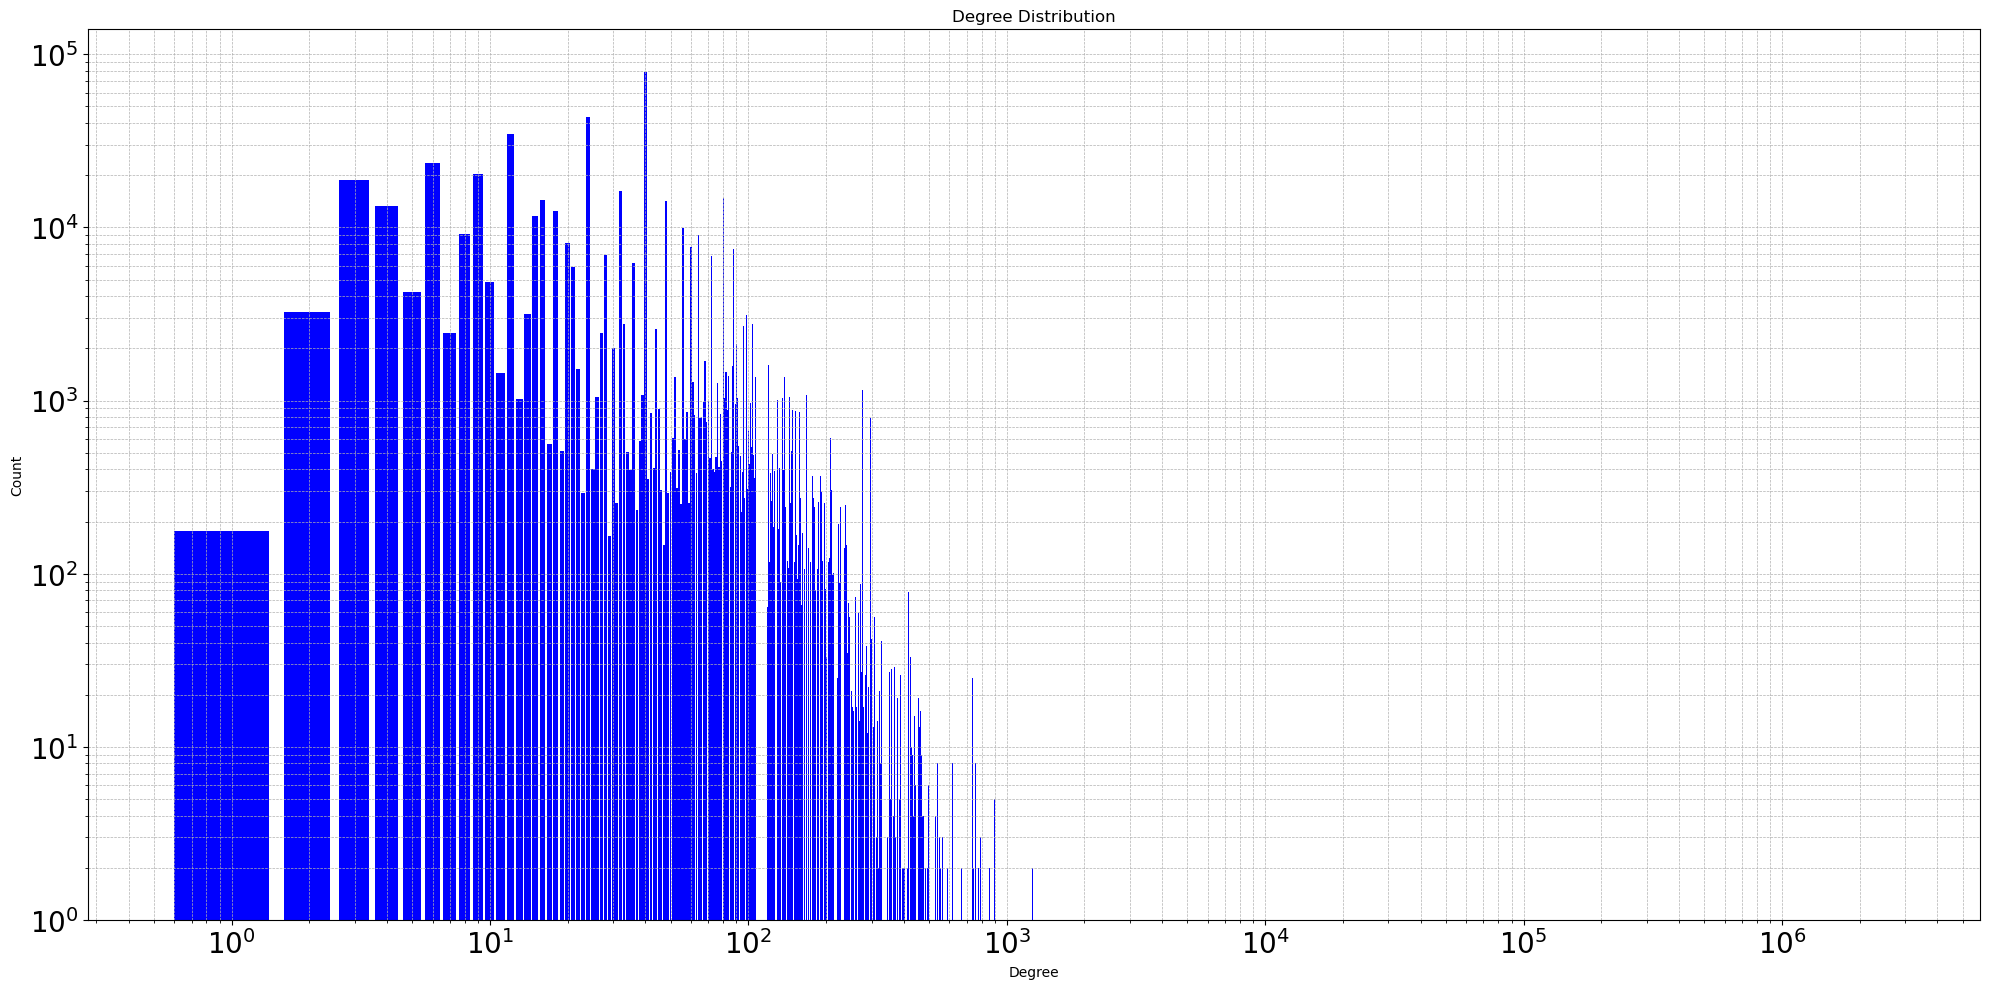

In [48]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import numpy as np


degree_sequence = dict(G.degree()).values()
degree_count = Counter(degree_sequence)

degrees, counts = zip(*degree_count.items())


plt.figure(figsize=(20, 10))  
plt.bar(degrees, counts, color='blue')  

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.ylim(bottom=1)

plt.tight_layout()

plt.show()

In [8]:

def count_matching_proteins(node_name_lists, protein_names):

    actual_node_names = [json.loads(names) for names in node_name_lists]

    protein_set = set(protein_names)


    all_node_names = set()
    for names in actual_node_names:
        all_node_names.update(names)

    matched_proteins = protein_set.intersection(all_node_names)
    all_proteins_exist = protein_set.issubset(all_node_names)

    return matched_proteins, len(matched_proteins), all_proteins_exist




# G = nx.read_graphml("aggregated_proteins_v70_subgraph.graphml")
G = load_graph_from_pickle('combined_graph.pkl')
node_names_list = list(nx.get_node_attributes(G, 'name').values()) 
matched_proteins, matched_count, all_proteins_exist = count_matching_proteins(node_names_list, existing_proteins_list)
# print("Matched proteins:", matched_proteins)
print("Number of matched proteins:", matched_count)




Number of matched proteins: 1549


In [54]:


node = "1054491"
# from itertools import islice
# print("protein info",G.nodes[node])
# degree = G.degree[node]
# print(f"The number of connected nodes to node {node} is: {degree}")

name_list = G.nodes[node]['dbId']
print(name_list)


Component 1: 50164
9918408


In [1]:
def convert_node_labels_to_integers(graph):
    """
    Convert the node labels of a NetworkX graph to integers.
    
    Parameters:
    - graph: NetworkX graph with any type of node labels.
    
    Returns:
    - A new NetworkX graph with node labels converted to integers.
    """
    # Create a mapping from old labels to new ones (integers)
    mapping = {node: i for i, node in enumerate(graph.nodes())}
    # Use relabel_nodes to create a new graph with integer labels
    graph_int_labels = nx.relabel_nodes(graph, mapping)
    
    return graph_int_labels

In [51]:
degrees = [degree for node, degree in G.degree()]
s = set()
for node, degree in G.degree():
    if degree == 115:
        s.update(G.neighbors(node))

print(s)
print(len(s))

{'1054491', '2051873', '2289970', '628247', '1041415', '1041233', '2083034', '1333730', '56006', '2086707', '2275823', '1208386', '602612', '111839', '935053', '1031369', '1567951', '2144028', '642718', '644877', '1943034', '1221761', '1305751', '1332004', '261981', '163700', '1416632', '460906', '836696', '2053885', '483302', '2285352', '2226362', '756203', '2271745', '2097274', '2089925', '231258', '1075392', '756364', '264440', '430960', '766015', '1309375', '2260413', '2276652', '2053971', '215292', '955162', '1944843', '134416', '2054860', '1332855', '2177491', '391394', '755581', '2126260', '2260680', '1383289', '793299', '2054912', '1704609', '1245081', '2033501', '1942348', '1831699', '1460631', '726090', '642647', '1385288', '431694', '1944172', '1842869', '83121', '2084987', '780074', '2085497', '2179227', '865939', '756591', '778809', '2282775', '897446', '1498595', '1384052', '2176650', '431915', '644881', '1802575', '1616668', '1333573', '1078726', '780062', '1302879', '13

# Forest Fire Sampling

In [12]:
import networkx as nx
from littleballoffur import ForestFireSampler

graph = load_graph_from_pickle('combined_graph.pkl')
graph = convert_node_labels_to_integers(graph)
model = ForestFireSampler(20000)
ff_graph = model.sample(graph)
print(ff_graph)



MultiGraph with 20000 nodes and 803064 edges


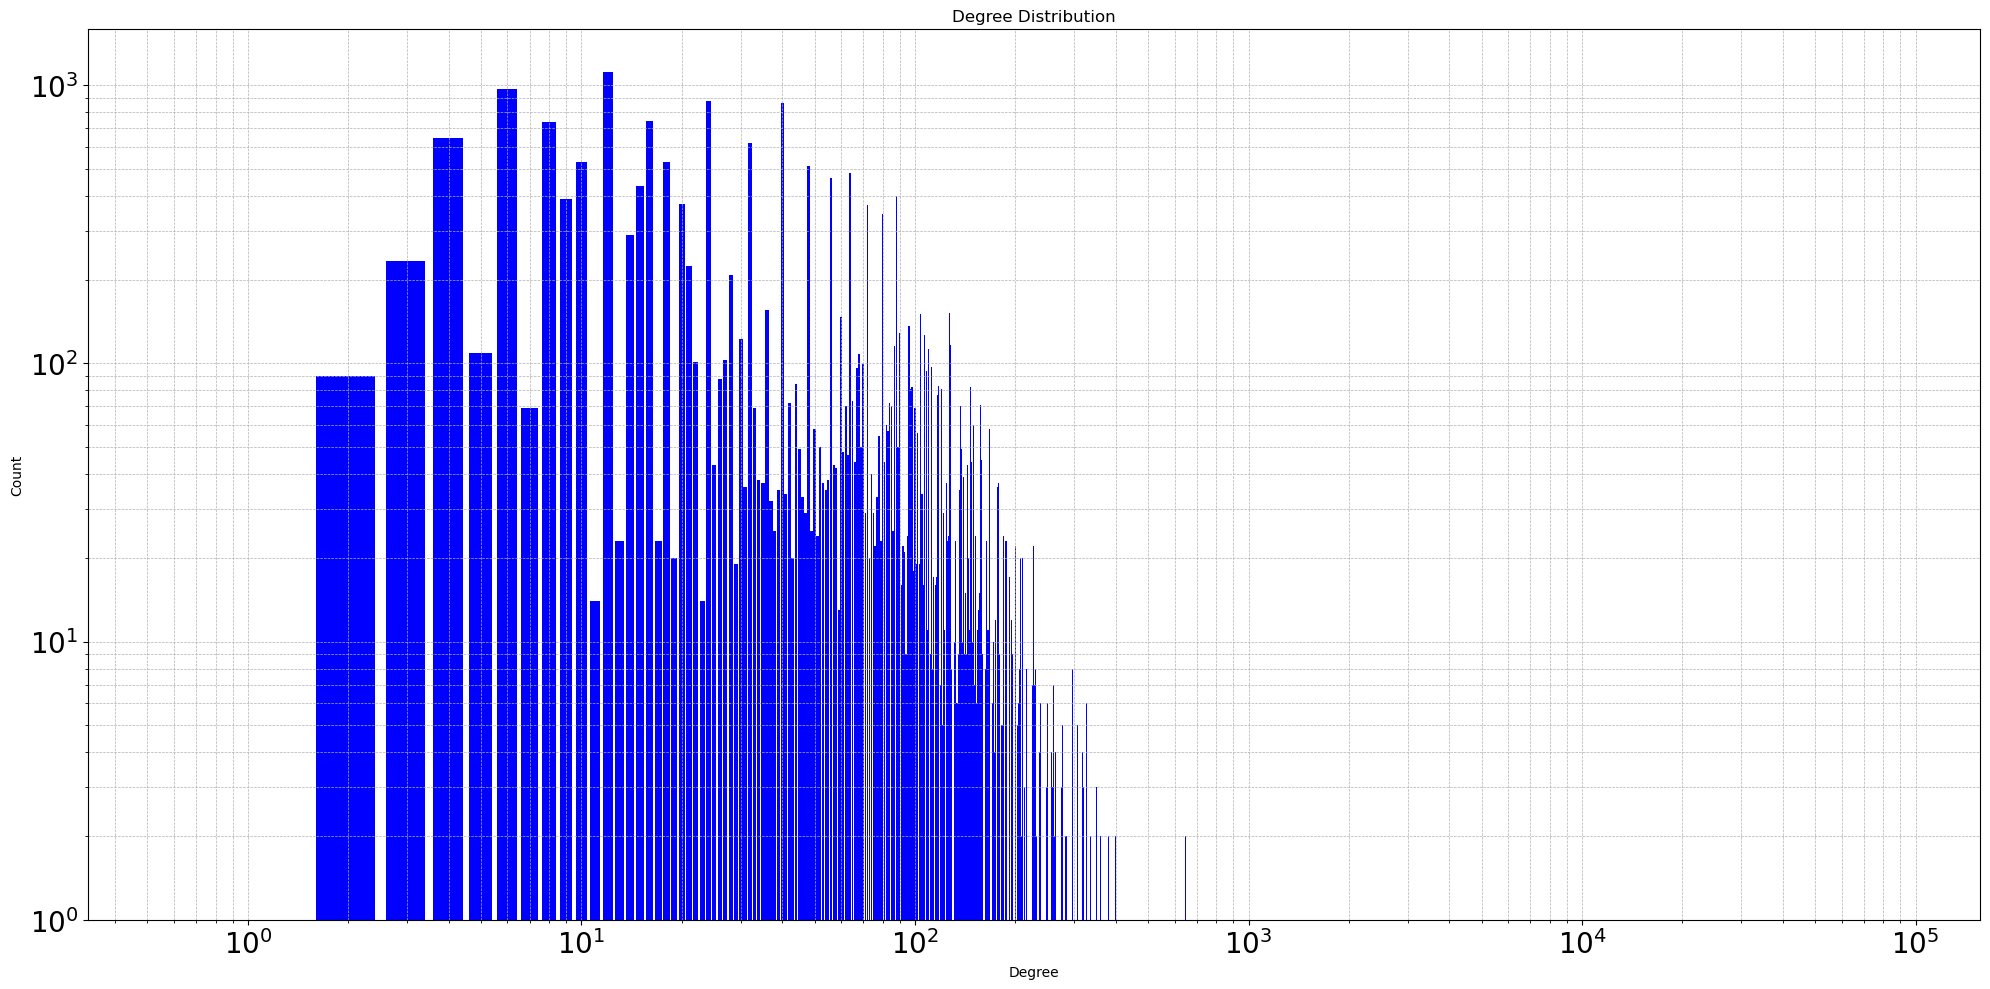

In [49]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import numpy as np


degree_sequence = dict(ff_graph.degree()).values()
degree_count = Counter(degree_sequence)

degrees, counts = zip(*degree_count.items())


plt.figure(figsize=(20, 10))  
plt.bar(degrees, counts, color='blue')  

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.ylim(bottom=1)

plt.tight_layout()

plt.show()


# Random Walk with Restart

In [4]:
from littleballoffur import RandomWalkWithRestartSampler

graph = load_graph_from_pickle('combined_graph.pkl')
graph = convert_node_labels_to_integers(graph)
model = RandomWalkWithRestartSampler(20000)
rw_graph = model.sample(graph)
print(rw_graph)
# visualize_graph(rw_graph)

MultiGraph with 20000 nodes and 896430 edges


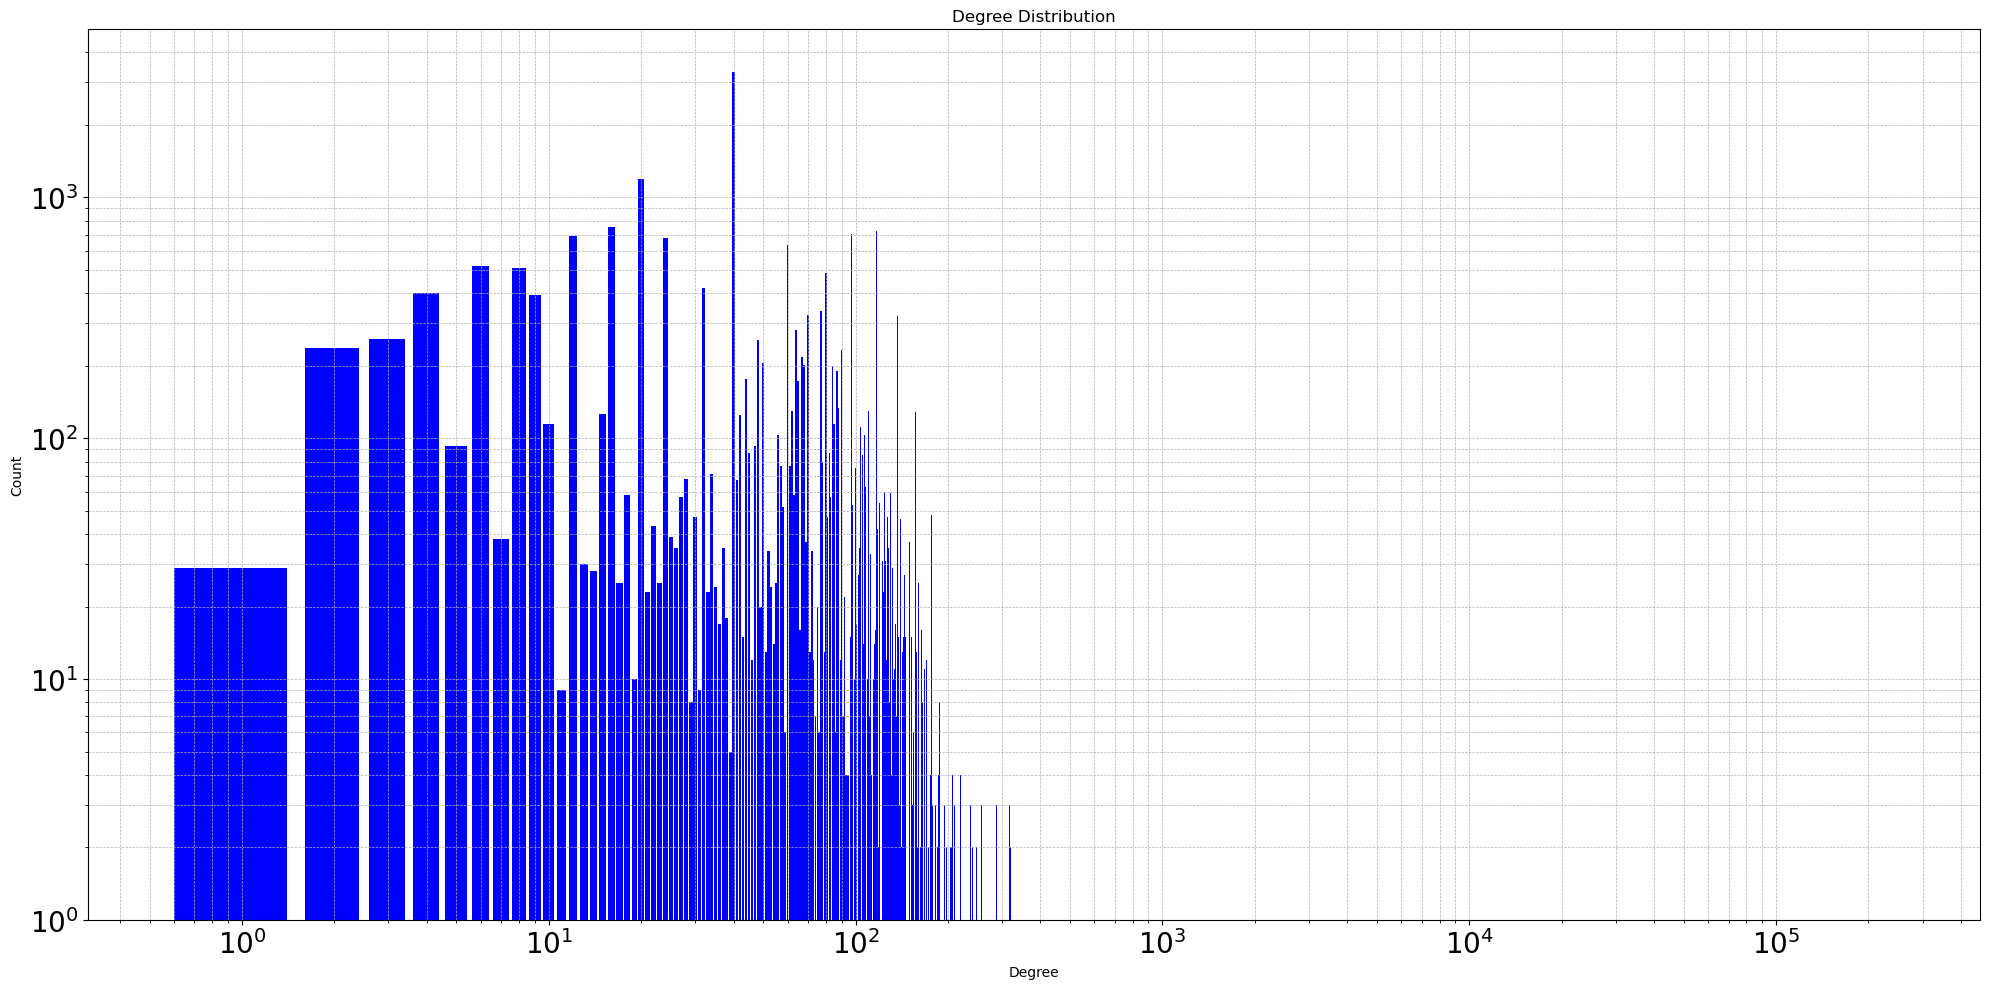

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import numpy as np


degree_sequence = dict(rw_graph.degree()).values()
degree_count = Counter(degree_sequence)

degrees, counts = zip(*degree_count.items())


plt.figure(figsize=(20, 10))  
plt.bar(degrees, counts, color='blue')  

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.ylim(bottom=1)

plt.tight_layout()

plt.show()

# Cluster-GCN

In [ ]:
# import networkx as nx
# from torch_geometric.utils import from_networkx

# G = nx.read_graphml('aggregated_proteins_v2.graphml')

# node_attrs = set()
# for _, node_data in G.nodes(data=True):
#     node_attrs.update(node_data.keys())

# # Initialize missing attributes with None or a default value
# for _, node_data in G.nodes(data=True):
#     for attr in node_attrs:
#         if attr not in node_data:
#             node_data[attr] = None  # or some default value

# data = from_networkx(G)


In [12]:
import torch
from torch_geometric.data import Data, Dataset
import networkx as nx
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
import numpy as np

G = nx.read_graphml('aggregated_proteins_v30.graphml')


def preprocess_features(features):
    # Convert features to a numeric format, handle non-numeric cases
    processed_features = []
    for feature in features:
        try:
            # convert the features to float
            processed_features.append(float(feature))
        except ValueError:
            # Handle non-numeric feature (could implement encoding here)
            processed_features.append(0.0)  # Using 0.0 as a placeholder
    return processed_features

def normalize_features(features):
    features = np.array(features)
    mean = features.mean(axis=0, keepdims=True)
    std = features.std(axis=0, keepdims=True)
    # Avoid division by zero
    std[std == 0] = 1
    normalized_features = (features - mean) / std
    return normalized_features.tolist()

def from_networkx_to_torch_geometric(G):
    # Convert node indices to a continuous range
    mapping = {k: i for i, k in enumerate(G.nodes())}
    edges = torch.tensor([list(map(mapping.get, edge)) for edge in G.edges()], dtype=torch.long).t().contiguous()
    
    if G.nodes():
        # Extract a sample node to get feature keys (assumes at least one node exists)
        sample_features = next(iter(G.nodes(data=True)))[1]
        feature_keys = list(sample_features.keys())
        
        # Extract and preprocess features for all nodes
        features = []
        for _, node_features in G.nodes(data=True):
            node_feature_values = [node_features.get(key, 0) for key in feature_keys]
            processed_features = preprocess_features(node_feature_values)
            features.append(processed_features)
        
        # Normalize features
        features = normalize_features(features)
    else:
        # Default to a single feature of 0 if no nodes or features
        features = [[0]]

    # Convert features to a tensor
    x = torch.tensor(features, dtype=torch.float)

    # Create the Data object
    data = Data(x=x, edge_index=edges)
    
    return data

def create_masks_for_node_classification(data, train_percent=0.6, val_percent=0.2):
    num_nodes = data.num_nodes
    num_train = int(num_nodes * train_percent)
    num_val = int(num_nodes * val_percent)

    # Shuffle node indices
    indices = torch.randperm(num_nodes)

    # Assign masks
    data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    data.train_mask[indices[:num_train]] = True
    data.val_mask[indices[num_train:num_train + num_val]] = True
    data.test_mask[indices[num_train + num_val:]] = True

    return data


    
# node_attrs = set()
# for _, node_data in G.nodes(data=True):
#     node_attrs.update(node_data.keys())

# # Initialize missing attributes with None or a default value
# for _, node_data in G.nodes(data=True):
#     for attr in node_attrs:
#         if attr not in node_data:
#             node_data[attr] = None  # or some default value

# data = from_networkx(G)

data = from_networkx_to_torch_geometric(G)
# data = create_masks_for_node_classification(data)

# Creating a custom dataset
class CustomGraphDataset(Dataset):
    def __init__(self, data_list):
        super(CustomGraphDataset, self).__init__()
        self.data_list = data_list
    
    def len(self):
        return len(self.data_list)
    
    def get(self, idx):
        return self.data_list[idx]

# Assuming you have a list of Data objects, you can create a dataset like this:
dataset = CustomGraphDataset([data])

# Example usage
loader = DataLoader(dataset, batch_size=1, shuffle=True)

print(data)

Data(x=[50164, 11], edge_index=[2, 2256345])


In [13]:
from torch_geometric.loader import ClusterData
from torch_geometric.loader import ClusterLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# data = data.to(device)
torch.manual_seed(12345)
# Prepare cluster data
cluster_data = ClusterData(data, num_parts=8, recursive=True) 
# Create a loader to iterate over clusters
loader = ClusterLoader(cluster_data, batch_size=1, shuffle=True)  

print()
total_num_nodes = 0
for step, sub_data in enumerate(loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of nodes in the current batch: {sub_data.num_nodes}')
    print(sub_data)
    print()
    total_num_nodes += sub_data.num_nodes

print(f'Iterated over {total_num_nodes} of {data.num_nodes} nodes!')


cpu


Computing METIS partitioning...



Step 1:
Number of nodes in the current batch: 6270
Data(x=[6270, 11], edge_index=[2, 12537])

Step 2:
Number of nodes in the current batch: 6271
Data(x=[6271, 11], edge_index=[2, 50132])

Step 3:
Number of nodes in the current batch: 6270
Data(x=[6270, 11], edge_index=[2, 6269])

Step 4:
Number of nodes in the current batch: 6270
Data(x=[6270, 11], edge_index=[2, 37599])

Step 5:
Number of nodes in the current batch: 6271
Data(x=[6271, 11], edge_index=[2, 31340])

Step 6:
Number of nodes in the current batch: 6271
Data(x=[6271, 11], edge_index=[2, 112707])

Step 7:
Number of nodes in the current batch: 6270
Data(x=[6270, 11], edge_index=[2, 25070])

Step 8:
Number of nodes in the current batch: 6271
Data(x=[6271, 11], edge_index=[2, 6270])

Iterated over 50164 of 50164 nodes!


Done!


In [19]:
import torch
from torch_geometric.nn import GCNConv, GAE

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.dropout(x, p=0.5, train=self.training)
        x = self.conv2(x, edge_index)
        return x




In [20]:
print("Number of batches in loader:", len(loader))
for batch_idx, cluster in enumerate(loader):
    print(f"Batch {batch_idx} contains {cluster.num_nodes} nodes.")


Number of batches in loader: 8
Batch 0 contains 6270 nodes.
Batch 1 contains 6271 nodes.
Batch 2 contains 6271 nodes.
Batch 3 contains 6270 nodes.
Batch 4 contains 6270 nodes.
Batch 5 contains 6271 nodes.
Batch 6 contains 6271 nodes.
Batch 7 contains 6270 nodes.


In [22]:
num_epochs = 100


encoder = GCNEncoder(in_channels=11, out_channels=32)
model = GAE(encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


    
for epoch in range(num_epochs):  
    model.train()
    total_loss = 0
    for batch_idx, cluster in enumerate(loader):
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index)
        loss = model.recon_loss(z, data.edge_index)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch}, Average Loss: {avg_loss}")
    # print(f"Batch {cluster}, Loss: {loss.item()}")


Epoch 0, Average Loss: 0.9147572293877602
Epoch 1, Average Loss: 0.7809090241789818
Epoch 2, Average Loss: 0.7594896629452705
Epoch 3, Average Loss: 0.7695909142494202


KeyboardInterrupt: 

# Extra codes

In [ ]:
import torch
from torch_geometric.data import Data
import networkx as nx

def to_pyg_graph(G):
    # Convert edges to a list of tuples of integer node indices
    edge_index = torch.tensor([(u, v) for u, v in G.edges()], dtype=torch.long).t().contiguous()

    # Example for adding node features (modify as needed)
    x = torch.tensor([G.nodes[n].get('features', [0]) for n in G.nodes], dtype=torch.float)
    
    # Create the Data object
    data = Data(x=x, edge_index=edge_index)
    
    return data


In [ ]:
from torch_geometric.data import Dataset

class CustomGraphDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(CustomGraphDataset, self).__init__(root, transform, pre_transform)
        # self.data = torch.load(self.processed_paths[0])
        self.data_list = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # Return a list of files in `self.raw_dir` which need to be found in order to skip the download.
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    # def download(self):
    #     # Download to `self.raw_dir`.

    def process(self):
        # Read data into huge `Data` list.
        G = nx.read_graphml('aggregated_proteins_v2.graphml')
        G = nx.convert_node_labels_to_integers(G)
        data_list = [to_pyg_graph(G)]

        # If there's a pre-transform, apply it
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
    
        # Save the list of Data objects
        torch.save(data_list, self.processed_paths[0])
        


    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]


In [ ]:
from torch_geometric.loader import DataLoader

# Assuming 'CustomGraphDataset' is your dataset class
dataset = CustomGraphDataset(root='')

# Use the DataLoader to handle batching
loader = DataLoader(dataset, batch_size=32, shuffle=True)

train_features = next(iter(loader))
print(train_features)

In [ ]:
# Print information about the graph (optional)
print(f"Loaded graph with {g.vcount()} nodes and {g.ecount()} edges.")

g.vs.attribute_names()
node_types = g.vs['schemaClass']
unique_node_types = set(node_types)
print("Unique Node Types:", unique_node_types)

In [ ]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

In [ ]:
import networkx as nx
from stellargraph import StellarGraph

# Load the graph from a GraphML file
nx_graph = nx.read_gml('agg.gml')

# Convert the NetworkX graph to a StellarGraph object.
stellargraph = StellarGraph.from_networkx(nx_graph)
stellargraph.info()

In [ ]:
hinsage_generator = HinSAGENodeGenerator(
    stellargraph, batch_size=1000, num_samples=[5]
)

hinsage_model = HinSAGE(
    layer_sizes=[128], activations=["relu"], generator=hinsage_generator
)
hinsage_acc = run_deep_graph_infomax(hinsage_model, hinsage_generator, epochs=epochs)

print(f"Test classification accuracy: {hinsage_acc}")